In [39]:
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [40]:
data = pd.read_excel("Inflationrate.xlsx")
data.index = data["Date"]
data = data.drop(["Date"], axis =1)
data

,Ukraine,Russie,UE,United States,Canada
Date,,,,,
2021-05-01,9.5,6.02,2.0,5.0,3.6
2021-06-01,9.5,6.50,2.2,5.4,3.1
2021-07-01,10.2,6.50,2.5,5.4,3.7
2021-08-01,10.2,6.68,3.2,5.3,4.1
2021-09-01,11.0,7.40,3.6,5.4,4.4
2021-10-01,10.9,8.13,4.4,6.2,4.7
2021-11-01,10.3,8.40,5.2,6.8,4.7
2021-12-01,10.0,8.39,5.3,7.0,4.8
2022-01-01,10.0,8.73,5.6,7.5,5.1


In [41]:
data_to_focus = data[["Ukraine"]]


In [42]:
# This function will generate a dataframe out of a time series list
def time_to_df(list1, number_of_attributes = 3):
    df = pd.DataFrame(columns=range(number_of_attributes))
    
    for i in range(len(list1)-number_of_attributes+1):
        record = []
        for j in range(i,i+number_of_attributes):
            record.append(list1[j])
        df.loc[len(df.index)] = record
        
        
    return df


def forecasted_series_to_df(series, forecasted_series_, npast_year, name_of_forecasted_column, name_of_datetime_index_column):
    
    forecasted_series = forecasted_series_.copy()
    y = 0
    index_for_forcaste = []
    index_for_forcaste.append(series.index[-npast_year-1]+ pd.DateOffset(months=1))
    for i in range(1,len(forecasted_series)):
        y = y+1
        date_temp = index_for_forcaste[-1]
        date_temp = date_temp + pd.DateOffset(months=1)
        index_for_forcaste.append(date_temp)

    forecasted_series.index = pd.to_datetime(index_for_forcaste)
    forecasted_series = pd.DataFrame({name_of_datetime_index_column:forecasted_series.index, name_of_forecasted_column:forecasted_series.values})
    forecasted_series.index = forecasted_series[name_of_datetime_index_column]
    forecasted_series = forecasted_series.drop(name_of_datetime_index_column, axis = 1)

    return forecasted_series

# This function trains the model using the input data(dataframe)
def train_and_forecast(list1, number_of_forecast = 5, npast_year =0, number_of_attributes = 3):

    input1 = time_to_df(list1, number_of_attributes)
    # We take last column of the features as target and rest are taken as attributes
    featureMat = input1.iloc[:, : len(input1.columns) - 1]
    label = input1[input1.columns[-1]]
    train_features, test_features, train_res, test_res= train_test_split(featureMat,label,test_size=0.4)
    
    # Here we are using linear regression model
    #model = linear_model.LinearRegression()
    model = linear_model.ElasticNet(alpha = 0.7)
    model.fit(train_features, train_res)
    test_result = model.predict(test_features)
    # Checking for the score
    #print("Score (R2 score): ", model.score(test_features, test_res))
    print("MSE Score: ", int(100*((1/len(test_res))*np.sum(test_result - test_res))*(1/len(test_res))*np.sum(test_result - test_res))/100)

    forecasted_values = []
    if(npast_year != 0):
        list_for_forcasting = list1[:-npast_year]
    else:
        list_for_forcasting = list1
    for i in range(number_of_forecast+npast_year):
        
        features_for_forecast = list_for_forcasting[-number_of_attributes+1:]
        forecasted_value = model.predict([features_for_forecast])[0]
        forecasted_values.append(forecasted_value)
        list_for_forcasting.append(forecasted_value)
        
    return forecasted_values

    

def forecast(series, nforecast_year = 10, npast_year =0, p = 3):

    number_of_forecast = nforecast_year
    
    # Generate predictions
    forecasts = train_and_forecast(series.to_list(), number_of_forecast, npast_year, p+1)
    forecasts_ser = pd.Series(forecasts, copy=False)
    to_plot=forecasted_series_to_df(series, forecasts_ser, npast_year, str(series.name), "Date")

    return to_plot, series

    

In [43]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import dateutil.parser # for handling the conversion of datetime formats
from datetime import timedelta # for operating the datetime objects
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_sarima_model(X, arima_order):

    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()

    for t in range(len(test)):
        model = SARIMAX(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):

    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None

    for p in p_values:

        for d in d_values:

            for q in q_values:

                order = (p,d,q)
                try:
                    rmse = evaluate_sarima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    
                except:
                    continue

    return best_cfg, best_score






Forecasting the inflation for country:  Ukraine
############################################################
########################################
SARIMAX model
MSE Score:  1.82
########################################
########################################
AR1 model
MSE Score:  0.23
########################################
########################################
AR2 model
MSE Score:  0.39
########################################
########################################
AR3 model
MSE Score:  3.39
########################################
########################################
AR4 model
MSE Score:  0.08
########################################
########################################
AR5 model
MSE Score:  0.78
########################################


Calendar,GMT,Reference,OurForecast,lowest_possible,highest_possible
2022-03-01,09:15 PM,Mar,11.6%,9.8%,13.4%
2022-04-01,09:15 PM,Apr,15.9%,14.1%,17.7%
2022-05-01,09:15 PM,May,19.0%,17.2%,20.8%
2022-06-01,09:15 PM,Jun,19.9%,18.1%,21.8%
2022-07-01,09:15 PM,Jul,22.8%,21.0%,24.6%
2022-08-01,09:15 PM,Aug,22.4%,20.6%,24.2%
2022-09-01,09:15 PM,Sep,23.8%,20.3%,27.3%
2022-10-01,09:15 PM,Oct,23.4%,17.8%,28.9%
2022-11-01,09:15 PM,Nov,24.8%,16.7%,32.9%
2022-12-01,09:15 PM,Dec,26.5%,16.2%,36.7%


Calendar,GMT,Reference,Actual,Previous,Consensus,OurForecast
2022-03-01,09:15 PM,Mar,13.7%,10.7%,11.5%,11.6%
2022-04-01,09:15 PM,Apr,16.4%,13.7%,13.7%,15.9%
2022-05-01,09:15 PM,May,18.0%,16.4%,15.5%,19.0%
2022-06-01,09:15 PM,Jun,21.5%,18.0%,16.6%,19.9%
2022-07-01,09:15 PM,Jul,21.9%,21.5%,18.5%,22.8%
2022-08-01,09:15 PM,Aug,,21.9%,19.3%,22.4%
2022-09-01,09:15 PM,Sep,,,20.9%,23.8%
2022-10-01,09:15 PM,Oct,,,22.2%,23.4%
2022-11-01,09:15 PM,Nov,,,24.4%,24.8%
2022-12-01,09:15 PM,Dec,,,27.2%,26.5%


############################################################







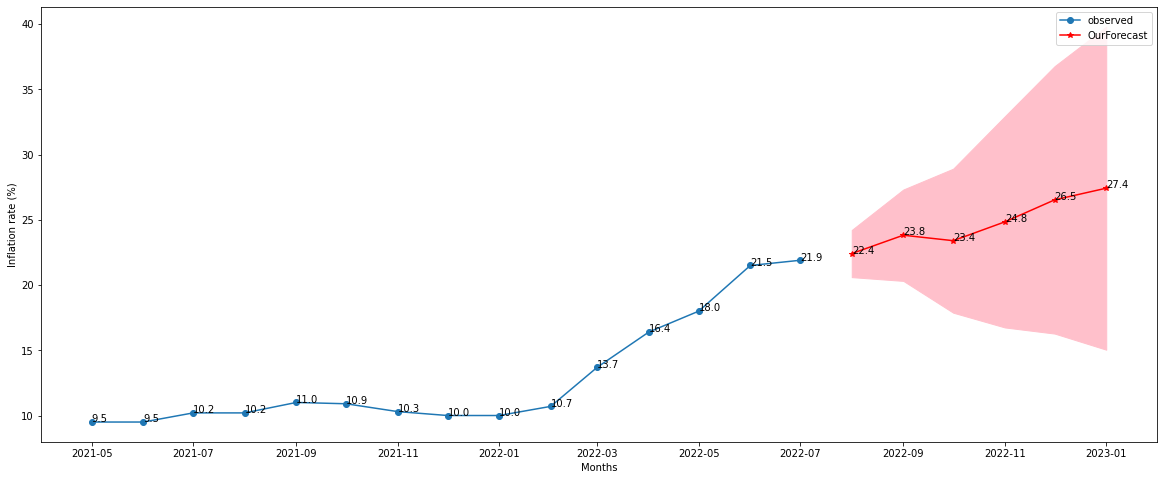

In [44]:


countries = data_to_focus.columns.to_list()

forecasted_dict = {}
past_year = 5
future_year = 6


# evaluate parameters
p_values = [0, 1, 2, 4]
d_values = range(0, 3)
q_values = range(0, 3)


for country in countries:
    print("Forecasting the inflation for country: ", country)
    print("#"*60)


    best_cfg, best_score = evaluate_models(data_to_focus[country].values, p_values, d_values, q_values)
    print("#"*40)
    print("SARIMAX model")
    print("MSE Score: ", int(100*best_score)/100)
    print("#"*40)
    model = SARIMAX(data_to_focus[country], order=best_cfg)
    results = model.fit()
    one_step_forecast = results.get_prediction(start=len(data_to_focus[country])-past_year-1,
                                               end = len(data_to_focus[country])+future_year-1)
    mean_forecast = one_step_forecast.predicted_mean
    print("#"*40)
    print("AR1 model")
    forecasted_1, actual = forecast(data_to_focus[country], nforecast_year = future_year,npast_year = past_year, p = 1)
    print("#"*40)
    print("#"*40)
    print("AR2 model")
    forecasted_2, actual = forecast(data_to_focus[country], nforecast_year = future_year,npast_year = past_year, p = 2)
    print("#"*40)
    print("#"*40)
    print("AR3 model")
    forecasted_3, actual = forecast(data_to_focus[country], nforecast_year = future_year,npast_year = past_year, p = 3)
    print("#"*40)
    print("#"*40)
    print("AR4 model")
    forecasted_4, actual = forecast(data_to_focus[country], nforecast_year = future_year,npast_year = past_year, p = 4)
    print("#"*40)
    print("#"*40)
    print("AR5 model")
    forecasted_5, actual = forecast(data_to_focus[country], nforecast_year = future_year,npast_year = past_year, p = 5)
    print("#"*40)

    forecasted = pd.DataFrame()
    forecasted.index = forecasted_1.index
    forecasted["AR1"] = forecasted_1[country]
    forecasted["AR2"] = forecasted_2[country]
    forecasted["AR3"] = forecasted_3[country]
    forecasted["AR4"] = forecasted_4[country]
    forecasted["AR5"] = forecasted_5[country]

    forecasted["SARIMAX"] = mean_forecast
    confidence_intervals = one_step_forecast.conf_int()
    
    lower_limits = confidence_intervals.loc[:,'lower '+country]
    upper_limits = confidence_intervals.loc[:,'upper '+country]

    forecasted["lowest_possible"] = lower_limits
    forecasted["highest_possible"] = upper_limits


    plt.figure(figsize =(20,8))
    plt.plot(data_to_focus[country].index, data_to_focus[country] ,label='observed', marker = "o")

    for x, y in zip(data_to_focus[country].index, data_to_focus[country]):
      plt.annotate(str(y), (x,y))

    plt.plot(mean_forecast.index[-future_year:], mean_forecast[-future_year:],color='r' ,label='OurForecast', marker = "*")
    for x, y in zip(mean_forecast.index[-future_year:], mean_forecast[-future_year:]):
      plt.annotate(str(int(y*10)/10), (x,y))
    # Shade uncertainty area
    plt.fill_between(mean_forecast.index[-future_year:], lower_limits[-future_year:], upper_limits[-future_year:], color='pink')


    # set labels, legends and show plot
    plt.xlabel('Months')
    plt.ylabel('Inflation rate (%)')
    plt.legend()


    forecasted_dict[country]= forecasted
    

for country in countries:
    
    

    previous = [str(int(i*10)/10)+"%" for i in data_to_focus[country].to_list()[-past_year-1:]]
    for i in range(future_year-1):
        previous.append(" ")
    
    actual = [str(int(i*10)/10)+"%" for i in data_to_focus[country].to_list()[-past_year:]]   
    for i in range(future_year):
        actual.append(" ")

    to_plot = forecasted_dict[country].copy()
    forecasted_dict[country]["Consensus"] = forecasted_dict[country].mean(axis = 1).apply(lambda x: str(int(x*10)/10)+"%")
    forecasted_dict_month = [i[0:3] for i in forecasted_dict[country].index.month_name()]
    forecasted_dict[country]["Reference"] = forecasted_dict_month
    forecasted_dict[country]["Actual"] = actual
    forecasted_dict[country]["Previous"] = previous
    forecasted_dict[country]["Calendar"] = forecasted_dict[country].index
    forecasted_dict[country]["GMT"] = datetime.datetime.now().strftime("%I:%M %p")
    forecasted_dict[country]["OurForecast"] = forecasted_dict[country]["SARIMAX"].apply(lambda x: str(int(x*10)/10)+"%")
    forecasted_dict[country]["lowest_possible"] = forecasted_dict[country]["lowest_possible"].apply(lambda x: str(int(x*10)/10)+"%")
    forecasted_dict[country]["highest_possible"] = forecasted_dict[country]["highest_possible"].apply(lambda x: str(int(x*10)/10)+"%")
    forecasted_dict[country]=forecasted_dict[country].drop(["AR1","AR2","AR3","AR4","AR5"], axis = 1)
    
    forecast_range = forecasted_dict[country][["Calendar","GMT","Reference","OurForecast","lowest_possible","highest_possible"]]
    forecast_range.index = forecast_range["Calendar"]
    forecast_range=forecast_range.drop(["Calendar"], axis = 1)
    forecast_range.columns.name = forecast_range.index.name
    forecast_range.index.name = None
    display(forecast_range)

    print("\n"*2)
    forecasted_dict[country] = forecasted_dict[country][["Calendar","GMT","Reference","Actual","Previous","Consensus","OurForecast"]]
    forecasted_dict[country].index = forecasted_dict[country]["Calendar"]
    forecasted_dict[country]=forecasted_dict[country].drop(["Calendar"], axis = 1)
    forecasted_dict[country].columns.name = forecasted_dict[country].index.name
    forecasted_dict[country].index.name = None

    
    display(forecasted_dict[country])
    print("#"*60)
    print("\n"*4)
